# ARM Team Project — Exploratory Data Analysis (EDA) — Basel-Land (2019)

## Goal of this notebook
This notebook performs non-graphical and graphical exploratory data analysis (EDA) on a cross-sectional municipality dataset for the year **2019**.

**Target variable (Y):**
- Average Rent CHF

**Predictors (X):**
- Tax Rate Natural Persons %
- Foreigners Share %
- Average Household Size
- Income per Taxpayer CHF

**Dataset:**
- Complete-case dataset exported from the data preparation notebook:
  `eda_dataset_2019_complete.csv`

## Libraries and settings

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
!apt-get update && apt-get install -y pandoc
!apt-get update && apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-latex-extra

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set(color_codes=True)

print("Working directory:", os.getcwd())


Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
Working directory: /workspaces/ARM_Gruppe-5/03 - EDA


## Export all figures (auto-save)

Goal:
- Automatically save every figure created after this cell into one folder
- File naming includes an incrementing number + timestamp
- Then re-run the plotting cells (or run notebook from top) to export all plots

Output:
- PNG files saved in: ./exports_figures_2019/


In [2]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Folder to store exported figures
EXPORT_DIR = "/workspaces/ARM_Gruppe-5/03 - EDA/exports_figures_2019"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Counter for figure names
_export_counter = 0

# Keep original plt.show()
_original_show = plt.show

def show_and_save(*args, **kwargs):
    global _export_counter
    _export_counter += 1
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{_export_counter:02d}_{timestamp}.png"
    path = os.path.join(EXPORT_DIR, filename)
    
    # Save the current figure
    plt.gcf().savefig(path, dpi=300, bbox_inches="tight")
    
    # Then display it normally
    _original_show(*args, **kwargs)

# Activate auto-export (affects figures created AFTER this cell)
plt.show = show_and_save

print(f"Auto-export enabled. Figures will be saved to: {os.path.abspath(EXPORT_DIR)}")
print("Now re-run the plotting cells you want to export (or Run All below this cell).")


Auto-export enabled. Figures will be saved to: /workspaces/ARM_Gruppe-5/03 - EDA/exports_figures_2019
Now re-run the plotting cells you want to export (or Run All below this cell).


## Load dataset

We load the complete-case cross-sectional dataset for 2019:
`eda_dataset_2019_complete.csv`
## Import data

In [3]:
DATA_PATH = "/workspaces/ARM_Gruppe-5/03 - EDA/Data/eda_dataset_2019_complete.csv"

df = pd.read_csv(DATA_PATH, sep=",", encoding="utf-8")

print("Loaded df with shape:", df.shape)
df.head()


Loaded df with shape: (58, 8)


,Year,BFS ID,Municipality,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
0,2019,2762,Allschwil,"1,386.3910",58.0000,27.5400,2.0900,"69,297.6802"
1,2019,2841,Anwil,"1,273.5419",63.0000,6.0600,2.4400,"55,915.9676"
2,2019,2881,Arboldswil,"1,297.8560",60.0000,6.4100,2.4100,"71,971.1369"
3,2019,2821,Arisdorf,"1,492.7620",59.0000,11.5100,2.4200,"70,530.9441"
4,2019,2763,Arlesheim,"1,483.1575",45.0000,20.0400,2.1300,"87,560.1473"


## Quick dataset inspection

Goal:
- Confirm the dataset structure (rows, columns)
- Check column names and data types
- Ensure variables look plausible for EDA


In [4]:
print("Shape:", df.shape)

print("\nColumns:")
print(list(df.columns))

print("\nInfo:")
df.info()

df.head()


Shape: (58, 8)

Columns:
['Year', 'BFS ID', 'Municipality', 'Average Rent CHF', 'Tax Rate Natural Persons %', 'Foreigners Share %', 'Average Household Size', 'Income per Taxpayer CHF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        58 non-null     int64  
 1   BFS ID                      58 non-null     int64  
 2   Municipality                58 non-null     object 
 3   Average Rent CHF            58 non-null     float64
 4   Tax Rate Natural Persons %  58 non-null     float64
 5   Foreigners Share %          58 non-null     float64
 6   Average Household Size      58 non-null     float64
 7   Income per Taxpayer CHF     58 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 3.8+ KB


,Year,BFS ID,Municipality,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
0,2019,2762,Allschwil,"1,386.3910",58.0000,27.5400,2.0900,"69,297.6802"
1,2019,2841,Anwil,"1,273.5419",63.0000,6.0600,2.4400,"55,915.9676"
2,2019,2881,Arboldswil,"1,297.8560",60.0000,6.4100,2.4100,"71,971.1369"
3,2019,2821,Arisdorf,"1,492.7620",59.0000,11.5100,2.4200,"70,530.9441"
4,2019,2763,Arlesheim,"1,483.1575",45.0000,20.0400,2.1300,"87,560.1473"


## Integrity checks (one row per municipality)

Goal:
- Confirm each municipality appears only once (cross-sectional data)
- Confirm BFS ID appears only once


In [5]:
dup_muni = df.duplicated(subset=["Municipality"]).sum()
dup_bfs = df.duplicated(subset=["BFS ID"]).sum()

print("Duplicate Municipality rows:", int(dup_muni))
print("Duplicate BFS ID rows:", int(dup_bfs))

print("\nUnique municipalities:", df["Municipality"].nunique())
print("Unique BFS IDs:", df["BFS ID"].nunique())


Duplicate Municipality rows: 0
Duplicate BFS ID rows: 0

Unique municipalities: 58
Unique BFS IDs: 58


## Missing values check

Goal:
- Confirm that the dataset is complete-case (no missing values)
- If missing values exist, identify which variables are affected


In [6]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

df_missing = pd.DataFrame({
    "MissingCount": missing_counts,
    "MissingPct": missing_pct
})

display(df_missing)

print("\nTotal missing cells:", int(df.isna().sum().sum()))


,MissingCount,MissingPct
Year,0,0.0000
BFS ID,0,0.0000
Municipality,0,0.0000
Average Rent CHF,0,0.0000
Tax Rate Natural Persons %,0,0.0000
Foreigners Share %,0,0.0000
Average Household Size,0,0.0000
Income per Taxpayer CHF,0,0.0000



Total missing cells: 0


# Univariate non-graphical EDA

## Descriptive statistics (overall)

Goal:
- Summarize central tendency and spread for the numeric variables
- Get an overview of rent levels and predictor distributions

Output:
- Summary statistics table (`describe()`)


In [7]:
# Numeric columns for EDA (exclude identifiers)
exclude_numeric = ["Year", "BFS ID"]
num_cols_eda = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_numeric]

print("Numeric EDA columns:", num_cols_eda)
display(df[num_cols_eda].describe().round(4))

Numeric EDA columns: ['Average Rent CHF', 'Tax Rate Natural Persons %', 'Foreigners Share %', 'Average Household Size', 'Income per Taxpayer CHF']


,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
count,58.0000,58.0000,58.0000,58.0000,58.0000
mean,"1,368.9158",58.5552,17.1057,2.2836,"65,373.9687"
std,165.2396,5.5339,8.1186,0.1320,"14,307.1603"
min,"1,003.3815",45.0000,6.0600,1.9500,"42,470.3713"
25%,"1,291.8872",56.0000,11.1900,2.1875,"55,637.5213"
50%,"1,344.5417",59.0000,14.8300,2.3000,"62,757.1970"
75%,"1,459.0957",63.0000,22.1425,2.3800,"70,129.0066"
max,"1,857.1357",69.5000,41.7500,2.5100,"118,429.5547"


## Quantiles (overall)

Goal:
- Inspect distributions beyond mean/std using quantiles
- Identify potential tail behavior and outliers

Output:
- Quantile table (5%, 10%, 25%, 50%, 75%, 90%, 95%) for EDA numeric variables


In [8]:
quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]
display(df[num_cols_eda].quantile(quantiles).round(4))


,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
0.0500,"1,074.1995",45.8500,6.8620,2.0870,"49,433.2602"
0.1000,"1,213.9941",52.0000,8.7840,2.1070,"51,872.8042"
0.2500,"1,291.8872",56.0000,11.1900,2.1875,"55,637.5213"
0.5000,"1,344.5417",59.0000,14.8300,2.3000,"62,757.1970"
0.7500,"1,459.0957",63.0000,22.1425,2.3800,"70,129.0066"
0.9000,"1,545.3623",64.4400,27.9900,2.4330,"81,219.6369"
0.9500,"1,632.8212",65.1500,30.2805,2.4545,"96,782.9937"


## Skewness and kurtosis

Goal:
- Check skewness (asymmetry) and kurtosis (tail heaviness) across municipalities
- Use this as an EDA diagnostic together with later plots

Output:
- Skewness and kurtosis table for EDA numeric variables


In [9]:
df_shape = pd.DataFrame({
    "Skewness": df[num_cols_eda].skew(),
    "Kurtosis": df[num_cols_eda].kurtosis()
}).round(4)

display(df_shape)


,Skewness,Kurtosis
Average Rent CHF,0.5669,1.5138
Tax Rate Natural Persons %,-0.7758,0.5719
Foreigners Share %,0.7816,-0.0191
Average Household Size,-0.4761,-0.2965
Income per Taxpayer CHF,1.5108,3.1087


## Extreme values (Rent)

Goal:
- Identify the municipalities with the highest and lowest average rent (CHF)

Output:
- Top 10 and bottom 10 municipalities by rent


In [10]:
target = "Average Rent CHF"

df_sorted = df.sort_values(target, ascending=False)

print("Top 10 municipalities by rent:")
display(df_sorted[["Municipality", target]].head(10))

print("\nBottom 10 municipalities by rent:")
display(df_sorted[["Municipality", target]].tail(10))

Top 10 municipalities by rent:


,Municipality,Average Rent CHF
43,Pfeffingen,"1,857.1357"
28,Hersberg,"1,833.8584"
7,Biel-Benken,"1,698.3284"
11,Bottmingen,"1,621.2611"
45,Ramlinsburg,"1,605.2245"
53,Therwil,"1,576.0893"
51,Schönenbuch,"1,532.1935"
57,Wintersingen,"1,521.1219"
31,Känerkinden,"1,520.9485"
22,Ettingen,"1,495.3950"



Bottom 10 municipalities by rent:


,Municipality,Average Rent CHF
42,Nenzlingen,"1,259.2182"
9,Birsfelden,"1,240.3278"
33,Laufen,"1,237.8637"
6,Bennwil,"1,218.8683"
56,Waldenburg,"1,202.6211"
19,Dittingen,"1,148.4646"
32,Langenbruck,"1,077.7950"
39,Läufelfingen,"1,053.8249"
15,Buckten,"1,038.4757"
36,Liesberg,"1,003.3815"


## Top/Bottom 5 municipalities for each variable

Goal:
- For each EDA variable, list:
  - Top 5 municipalities (highest values)
  - Bottom 5 municipalities (lowest values)

Output:
- Small tables for each variable (rent, tax, foreigners, household size, income per taxpayer)


In [11]:
# Variables we want top/bottom lists for (exclude identifiers)
vars_to_rank = [
    "Average Rent CHF",
    "Tax Rate Natural Persons %",
    "Foreigners Share %",
    "Average Household Size",
    "Income per Taxpayer CHF"
]

# Keep only those that exist (safety)
vars_to_rank = [v for v in vars_to_rank if v in df.columns]

for v in vars_to_rank:
    print("\n" + "="*80)
    print(f"Variable: {v}")
    print("="*80)

    # Top 5
    top5 = df.sort_values(v, ascending=False)[["Municipality", "BFS ID", v]].head(5)
    print("\nTop 5 municipalities:")
    display(top5)

    # Bottom 5
    bottom5 = df.sort_values(v, ascending=True)[["Municipality", "BFS ID", v]].head(5)
    print("\nBottom 5 municipalities:")
    display(bottom5)


Variable: Average Rent CHF

Top 5 municipalities:


,Municipality,BFS ID,Average Rent CHF
43,Pfeffingen,2772,"1,857.1357"
28,Hersberg,2827,"1,833.8584"
7,Biel-Benken,2764,"1,698.3284"
11,Bottmingen,2767,"1,621.2611"
45,Ramlinsburg,2832,"1,605.2245"



Bottom 5 municipalities:


,Municipality,BFS ID,Average Rent CHF
36,Liesberg,2788,"1,003.3815"
15,Buckten,2843,"1,038.4757"
39,Läufelfingen,2852,"1,053.8249"
32,Langenbruck,2888,"1,077.7950"
19,Dittingen,2784,"1,148.4646"



Variable: Tax Rate Natural Persons %

Top 5 municipalities:


,Municipality,BFS ID,Tax Rate Natural Persons %
56,Waldenburg,2895,69.5000
27,Grellingen,2786,67.0000
19,Dittingen,2784,66.0000
54,Titterten,2894,65.0000
37,Liestal,2829,65.0000



Bottom 5 municipalities:


,Municipality,BFS ID,Tax Rate Natural Persons %
4,Arlesheim,2763,45.0000
11,Bottmingen,2767,45.0000
43,Pfeffingen,2772,45.0000
7,Biel-Benken,2764,46.0000
8,Binningen,2765,48.0000



Variable: Foreigners Share %

Top 5 municipalities:


,Municipality,BFS ID,Foreigners Share %
44,Pratteln,2831,41.7500
23,Frenkendorf,2824,32.5700
9,Birsfelden,2766,30.6800
56,Waldenburg,2895,30.2100
24,Füllinsdorf,2825,29.4900



Bottom 5 municipalities:


,Municipality,BFS ID,Foreigners Share %
1,Anwil,2841,6.0600
2,Arboldswil,2881,6.4100
12,Bretzwil,2883,6.5900
6,Bennwil,2882,6.9100
52,Seltisberg,2833,7.6900



Variable: Average Household Size

Top 5 municipalities:


,Municipality,BFS ID,Average Household Size
6,Bennwil,2882,2.5100
50,Rümlingen,2859,2.5100
12,Bretzwil,2883,2.4800
13,Brislach,2782,2.4500
43,Pfeffingen,2772,2.4400



Bottom 5 municipalities:


,Municipality,BFS ID,Average Household Size
5,Augst,2822,1.9500
9,Birsfelden,2766,1.9600
36,Liesberg,2788,2.0700
0,Allschwil,2762,2.0900
32,Langenbruck,2888,2.1000



Variable: Income per Taxpayer CHF

Top 5 municipalities:


,Municipality,BFS ID,Income per Taxpayer CHF
11,Bottmingen,2767,"118,429.5547"
43,Pfeffingen,2772,"102,874.2041"
8,Binningen,2765,"99,143.8997"
7,Biel-Benken,2764,"96,366.3632"
4,Arlesheim,2763,"87,560.1473"



Bottom 5 municipalities:


,Municipality,BFS ID,Income per Taxpayer CHF
47,Roggenburg,2790,"42,470.3713"
32,Langenbruck,2888,"43,906.5727"
35,Lauwil,2889,"48,831.0566"
56,Waldenburg,2895,"49,539.5315"
36,Liesberg,2788,"50,890.1741"


# Multivariate non-graphical EDA

## Correlation and covariance matrices (EDA numeric variables)

Goal:
- Quantify linear relationships between rent and predictors (correlation)
- Inspect covariance as the unstandardized version (units matter)

Output:
- Correlation matrix table (EDA numeric variables only)
- Covariance matrix table (EDA numeric variables only)


In [12]:
corr = df[num_cols_eda].corr().round(4)
cov = df[num_cols_eda].cov().round(4)

print("Correlation matrix (EDA numeric variables):")
display(corr)

print("\nCovariance matrix (EDA numeric variables):")
display(cov)


Correlation matrix (EDA numeric variables):


,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
Average Rent CHF,1.0000,-0.5874,-0.0906,0.2534,0.6871
Tax Rate Natural Persons %,-0.5874,1.0000,-0.0575,-0.0022,-0.7629
Foreigners Share %,-0.0906,-0.0575,1.0000,-0.5619,0.0597
Average Household Size,0.2534,-0.0022,-0.5619,1.0000,0.1069
Income per Taxpayer CHF,0.6871,-0.7629,0.0597,0.1069,1.0000



Covariance matrix (EDA numeric variables):


,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
Average Rent CHF,"27,304.1146",-537.1378,-121.5617,5.5275,"1,624,333.7809"
Tax Rate Natural Persons %,-537.1378,30.6239,-2.5852,-0.0016,"-60,404.8019"
Foreigners Share %,-121.5617,-2.5852,65.9114,-0.6022,"6,938.5467"
Average Household Size,5.5275,-0.0016,-0.6022,0.0174,201.8660
Income per Taxpayer CHF,"1,624,333.7809","-60,404.8019","6,938.5467",201.8660,"204,694,836.7321"


## Univariate graphical EDA: Histogram (Average Rent CHF)

Goal:
- Visualize the distribution of the target variable across municipalities
- Check spread, skewness, and whether there are extreme values

Output:
- Histogram of Average Rent CHF


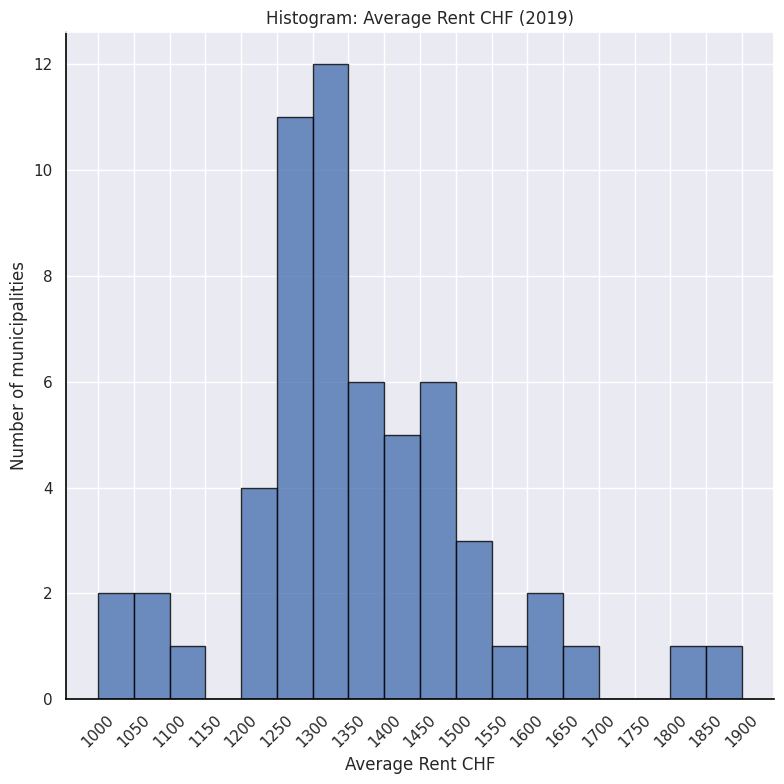

In [13]:
target = "Average Rent CHF"

x = df[target].dropna().values

# Define clean bin edges (50 CHF steps)
bin_width = 50
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,8))
plt.hist(x, bins=bins, edgecolor="black", linewidth=1, alpha=0.8)

plt.title("Histogram: Average Rent CHF (2019)")
plt.xlabel("Average Rent CHF")
plt.ylabel("Number of municipalities")

# Clean ticks: show every bin edge (or every 2nd if too crowded)
plt.xticks(bins, rotation=45)

# Make axes lines clearly visible
ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Univariate graphical EDA: Boxplot (Average Rent CHF)

Goal:
- Detect outliers and visualize spread using median and IQR

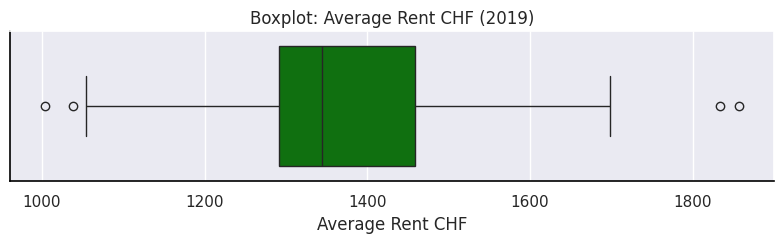

In [14]:
target = "Average Rent CHF"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[target], color="green", linewidth=1)

plt.title("Boxplot: Average Rent CHF (2019)")
plt.xlabel("Average Rent CHF")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Univariate graphical EDA: Density plot (Average Rent CHF)

Goal:
- Show a smooth distribution curve (shape, skewness, possible multiple peaks)

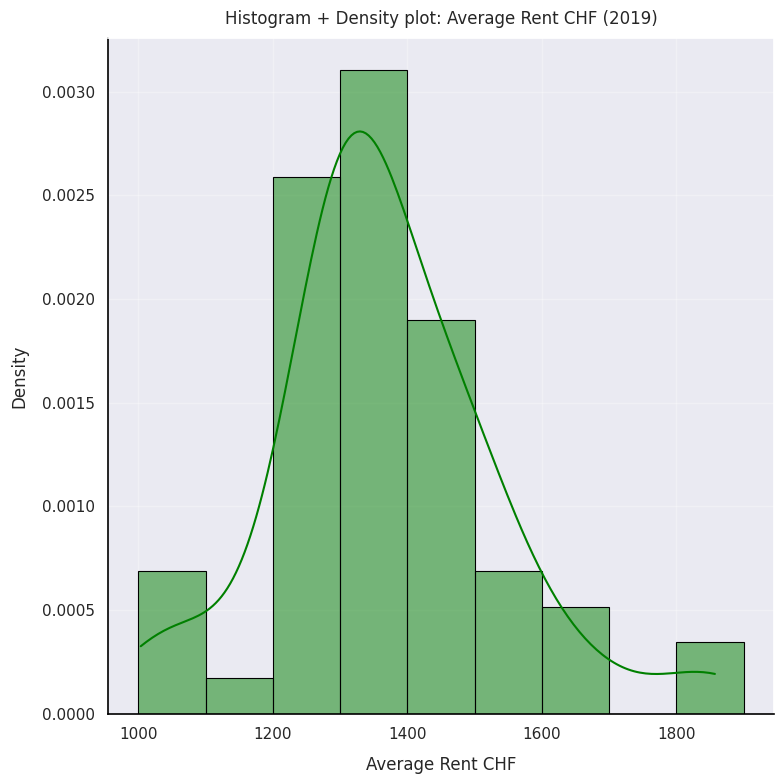

In [15]:
target = "Average Rent CHF"

# Define bins with size 100
x = df[target].dropna().values
bin_width = 100
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,8))
sns.histplot(df[target].dropna(), 
             stat="density",
             kde=True,
             bins=bins,
             color='green',
             edgecolor='black',
             linewidth=0.8
            )

plt.title("Histogram + Density plot: Average Rent CHF (2019)", fontsize=12, pad=10)
plt.xlabel("Average Rent CHF", fontsize=12, labelpad=10)
plt.ylabel("Density", fontsize=12, labelpad=10)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Univariate Graphical Data
## Boxplot Diagram of Average Rent per Year


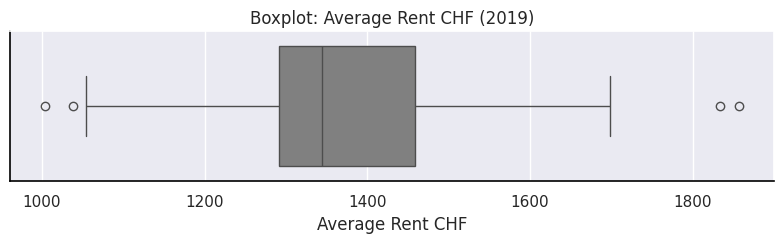

In [16]:
var = "Average Rent CHF"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[var], color="Grey", linewidth=1)

plt.title("Boxplot: Average Rent CHF (2019)")
plt.xlabel("Average Rent CHF")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: QQ plot (Average Rent CHF)

Goal:
- Compare rent distribution against a normal distribution
- Strong tail deviations indicate skewness/outliers/heavy tails

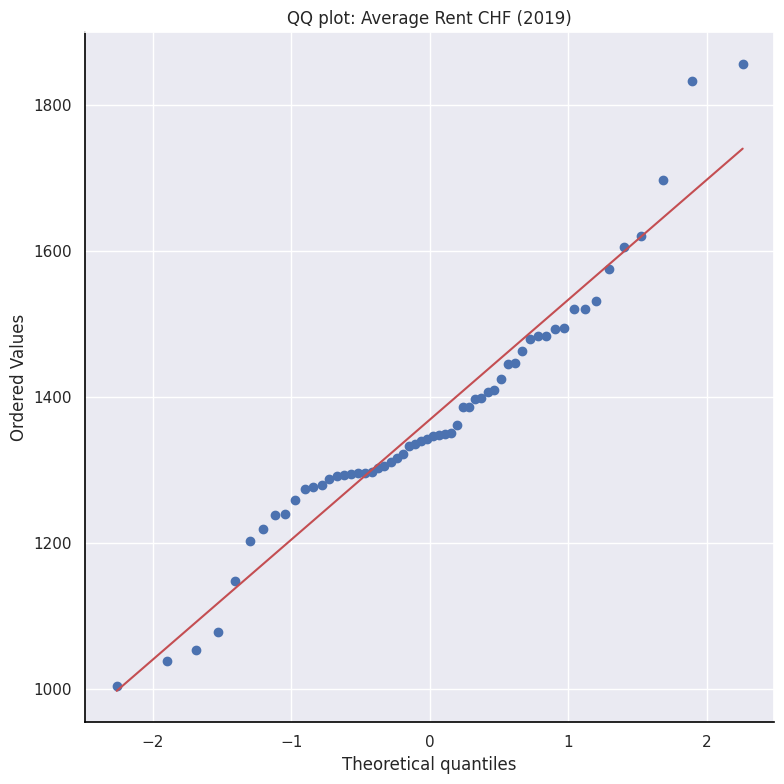

In [17]:
import scipy.stats as stats

target = "Average Rent CHF"

plt.figure(figsize=(8,8))
stats.probplot(df[target].dropna(), dist="norm", plot=plt)
plt.title("QQ plot: Average Rent CHF (2019)")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Univariate graphical EDA: Histogram (Tax Rate Natural Persons %)

Goal:
- Visualize distribution of municipal tax rate (natural persons)
- Use clean bin edges (1 percentage point steps)


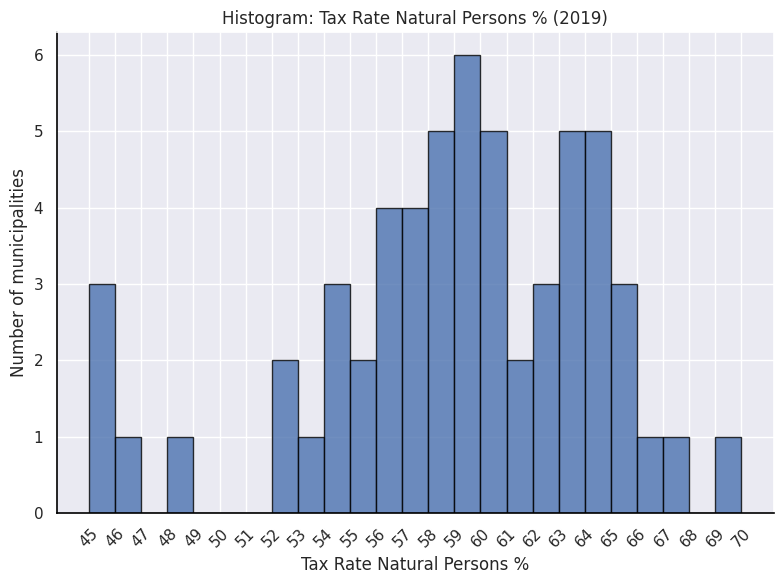

In [18]:
var = "Tax Rate Natural Persons %"
x = df[var].dropna().values

bin_width = 1
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,6))
plt.hist(x, bins=bins, edgecolor="black", linewidth=1, alpha=0.8)

plt.title("Histogram: Tax Rate Natural Persons % (2019)")
plt.xlabel("Tax Rate Natural Persons %")
plt.ylabel("Number of municipalities")
plt.xticks(bins, rotation=45)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Boxplot (Tax Rate Natural Persons %)

Goal:
- Identify spread and outliers in tax rates


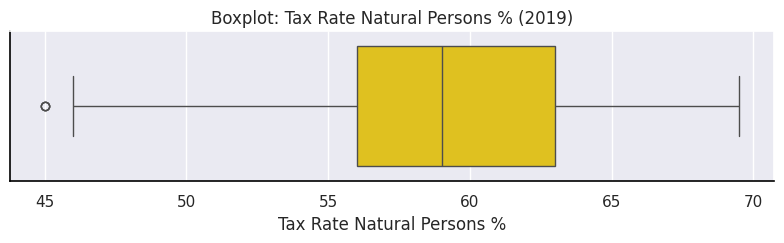

In [19]:
var = "Tax Rate Natural Persons %"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[var], color="gold", linewidth=1)

plt.title("Boxplot: Tax Rate Natural Persons % (2019)")
plt.xlabel("Tax Rate Natural Persons %")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Histogram (Foreigners Share %)

Goal:
- Visualize distribution of foreigners share across municipalities
- Use clean bin edges (2 percentage point steps)


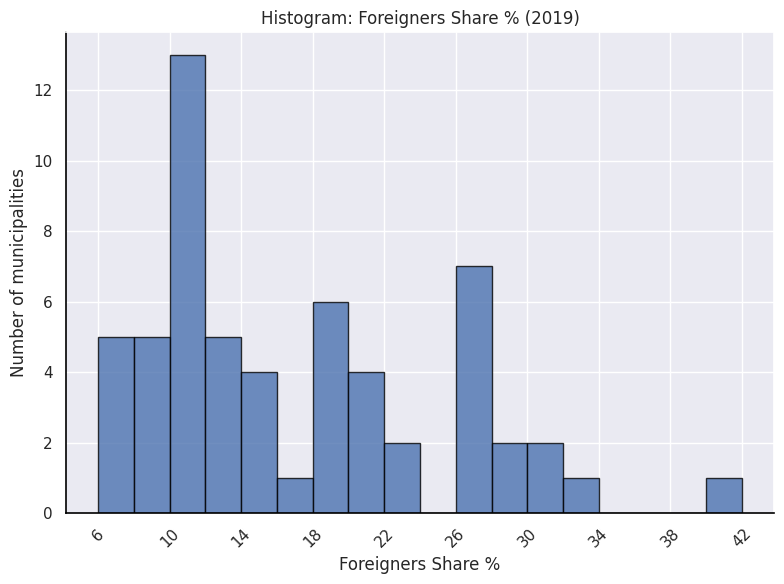

In [20]:
var = "Foreigners Share %"
x = df[var].dropna().values

bin_width = 2
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,6))
plt.hist(x, bins=bins, edgecolor="black", linewidth=1, alpha=0.8)

plt.title("Histogram: Foreigners Share % (2019)")
plt.xlabel("Foreigners Share %")
plt.ylabel("Number of municipalities")

# Avoid overcrowding ticks: show every 2nd tick
plt.xticks(bins[::2], rotation=45)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Boxplot (Foreigners Share %)

Goal:
- Identify spread and outliers in foreigners share


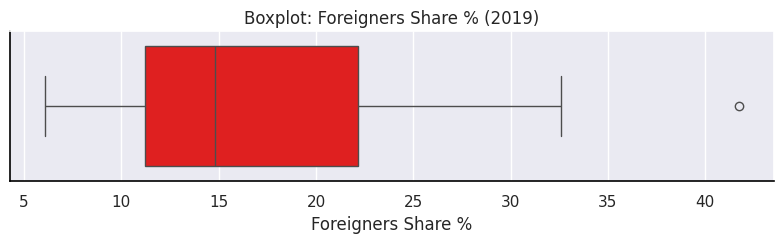

In [21]:
var = "Foreigners Share %"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[var], color="red", linewidth=1)

plt.title("Boxplot: Foreigners Share % (2019)")
plt.xlabel("Foreigners Share %")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Histogram (Average Household Size)

Goal:
- Visualize distribution of household size across municipalities
- Use clean bin edges (0.05 steps)


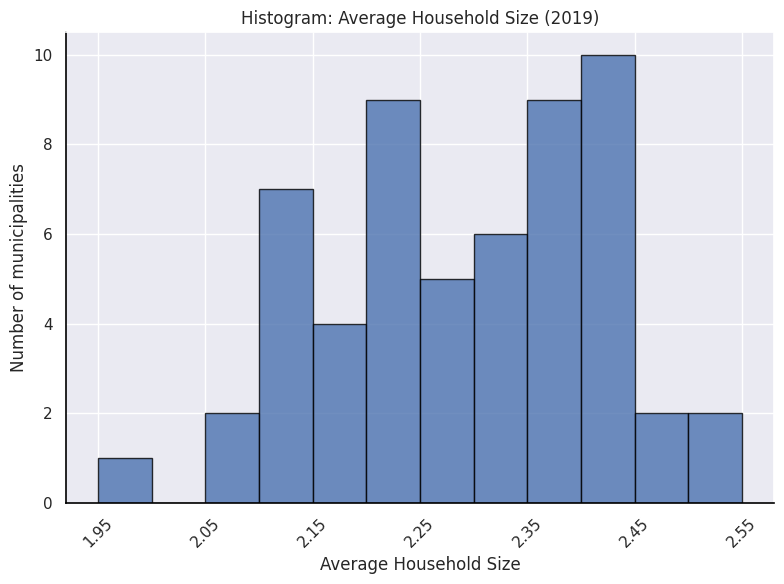

In [22]:
var = "Average Household Size"
x = df[var].dropna().values

bin_width = 0.05
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,6))
plt.hist(x, bins=bins, edgecolor="black", linewidth=1, alpha=0.8)

plt.title("Histogram: Average Household Size (2019)")
plt.xlabel("Average Household Size")
plt.ylabel("Number of municipalities")

# Avoid overcrowding: show every 2nd tick
plt.xticks(bins[::2], rotation=45)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Boxplot (Average Household Size)

Goal:
- Identify spread and outliers in household size


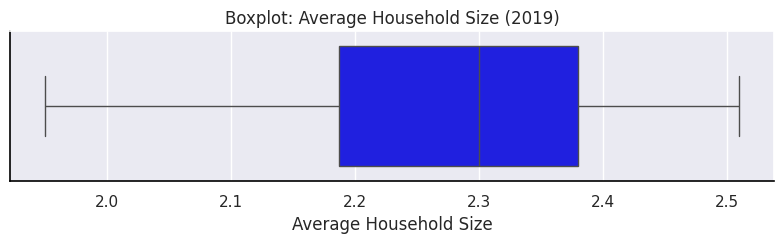

In [23]:
var = "Average Household Size"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[var], color="blue", linewidth=1)

plt.title("Boxplot: Average Household Size (2019)")
plt.xlabel("Average Household Size")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Histogram (Income per Taxpayer CHF)

Goal:
- Visualize distribution of wealth proxy across municipalities
- Use clean bin edges (5,000 CHF steps)


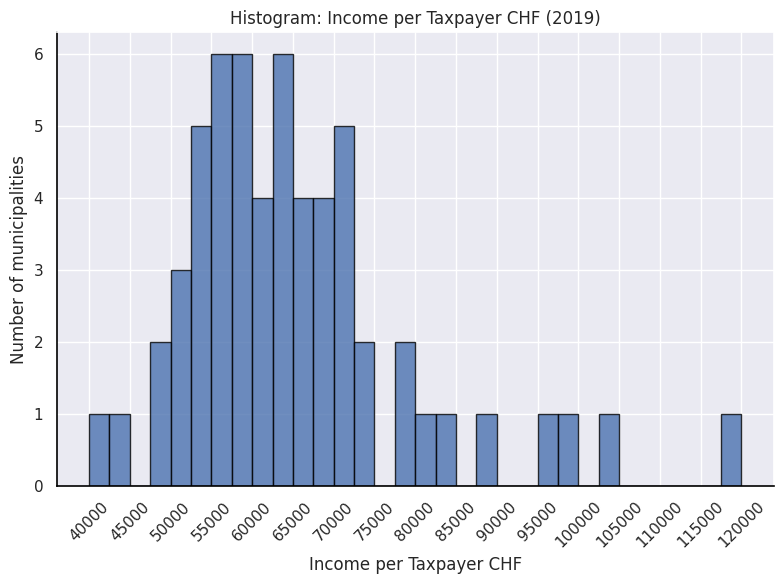

In [24]:
var = "Income per Taxpayer CHF"
x = df[var].dropna().values

bin_width = 2500
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)

plt.figure(figsize=(8,6))
plt.hist(x, bins=bins, edgecolor="black", linewidth=1, alpha=0.8)

plt.title("Histogram: Income per Taxpayer CHF (2019)")
plt.xlabel("Income per Taxpayer CHF")
plt.ylabel("Number of municipalities")

# Reduce tick crowding: show every 2nd tick
plt.xticks(bins[::2], rotation=45)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Univariate graphical EDA: Boxplot (Income per Taxpayer CHF)

Goal:
- Identify spread and outliers in income per taxpayer


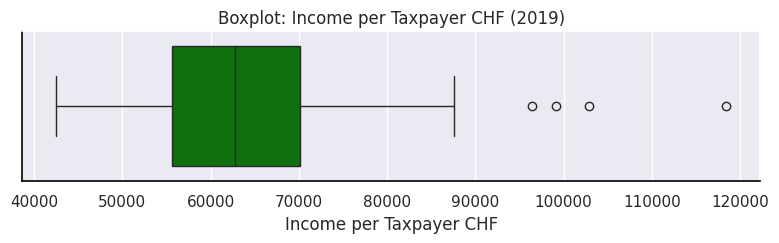

In [25]:
var = "Income per Taxpayer CHF"

plt.figure(figsize=(8,2.6))
sns.boxplot(x=df[var], color="green", linewidth=1)

plt.title("Boxplot: Income per Taxpayer CHF (2019)")
plt.xlabel("Income per Taxpayer CHF")

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Multivariate graphical EDA: Correlation heatmap

Goal:
- Visualize the correlation matrix for the EDA numeric variables
- Highlight which predictors are most associated with rent
- Detect multicollinearity among predictors (e.g., tax rate vs income per taxpayer)

Output:
- Correlation heatmap


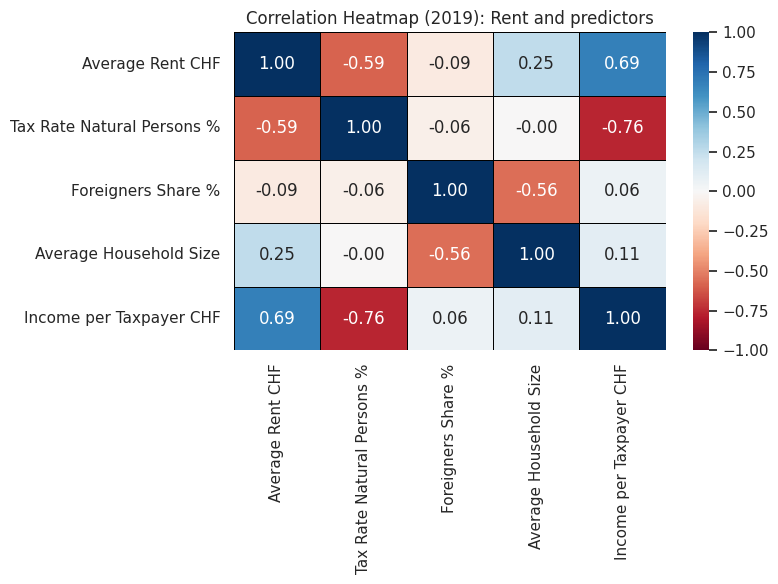

In [26]:
corr = df[num_cols_eda].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor="black",
    cmap="RdBu",        # red for negative, blue for positive
    center=0,           # make 0 the midpoint (white-ish)
    vmin=-1,
    vmax=1
)

plt.title("Correlation Heatmap (2019): Rent and predictors")
plt.tight_layout()
plt.show()


## Multivariate graphical EDA: Regression plot (Rent vs Income per Taxpayer)

Goal:
- Visualize relationship between rent and income per taxpayer
- Add regression line and confidence band (CI)

Output:
- Regression plot: Average Rent CHF vs Income per Taxpayer CHF


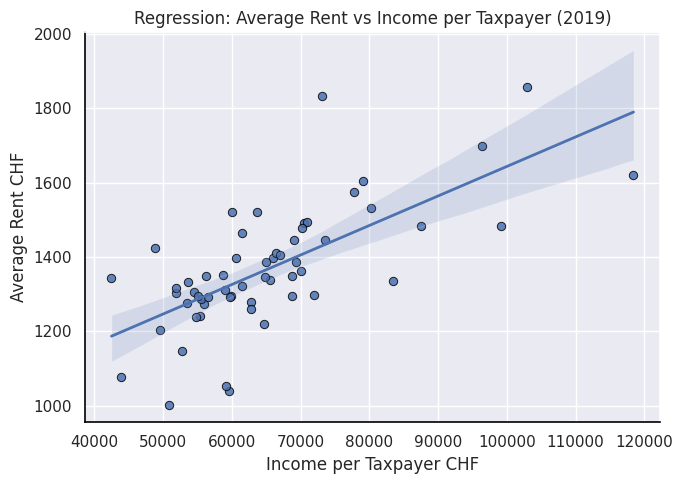

In [27]:
x_var = "Income per Taxpayer CHF"
y_var = "Average Rent CHF"

plt.figure(figsize=(7,5))
sns.regplot(
    data=df,
    x=x_var,
    y=y_var,
    ci=95,
    scatter_kws={"edgecolors": "black", "linewidths": 0.7, "alpha": 0.85},
    line_kws={"linewidth": 2}
)

plt.title("Regression: Average Rent vs Income per Taxpayer (2019)")
plt.xlabel(x_var)
plt.ylabel(y_var)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Multivariate graphical EDA: Regression plot (Rent vs Tax Rate)

Goal:
- Visualize relationship between rent and municipal tax rate
- Add regression line and confidence band (CI)

Output:
- Regression plot: Average Rent CHF per vs Tax Rate Natural Persons %


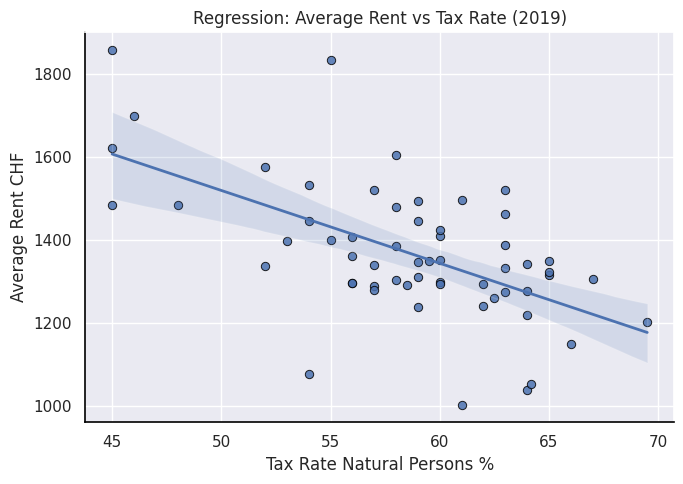

In [28]:
x_var = "Tax Rate Natural Persons %"
y_var = "Average Rent CHF"

plt.figure(figsize=(7,5))
sns.regplot(
    data=df,
    x=x_var,
    y=y_var,
    ci=95,
    scatter_kws={"edgecolors": "black", "linewidths": 0.7, "alpha": 0.85},
    line_kws={"linewidth": 2}
)

plt.title("Regression: Average Rent vs Tax Rate (2019)")
plt.xlabel(x_var)
plt.ylabel(y_var)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Multivariate graphical EDA: Regression plot (Rent vs Foreigners Share)

Goal:
- Visualize relationship between rent and foreigners share
- Add regression line and confidence band (CI)

Output:
- Regression plot: Average Rent CHF vs Foreigners Share %


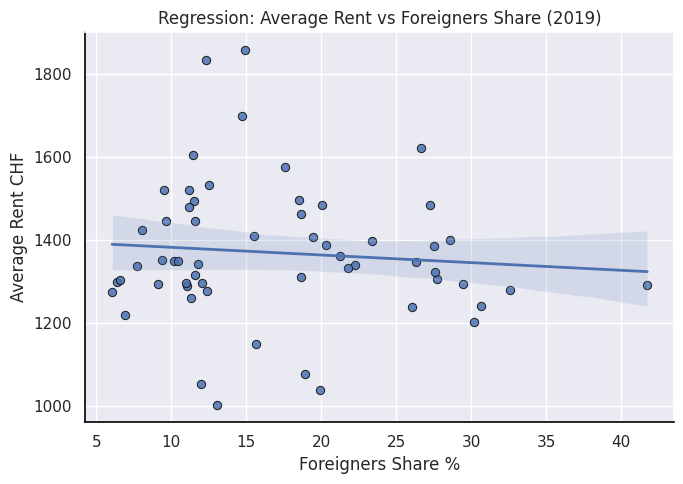

In [29]:
x_var = "Foreigners Share %"
y_var = "Average Rent CHF"

plt.figure(figsize=(7,5))
sns.regplot(
    data=df,
    x=x_var,
    y=y_var,
    ci=95,
    scatter_kws={"edgecolors": "black", "linewidths": 0.7, "alpha": 0.85},
    line_kws={"linewidth": 2}
)

plt.title("Regression: Average Rent vs Foreigners Share (2019)")
plt.xlabel(x_var)
plt.ylabel(y_var)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()


## Multivariate graphical EDA: Regression plot (Rent vs Average Household Size)

Goal:
- Visualize relationship between rent and average household size
- Add regression line and confidence band (CI)

Output:
- Regression plot: Average Rent CHF vs Average Household Size


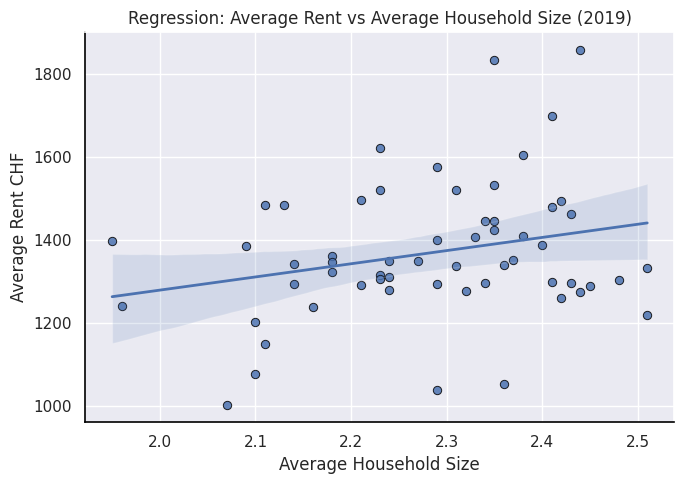

In [30]:
x_var = "Average Household Size"
y_var = "Average Rent CHF"

plt.figure(figsize=(7,5))
sns.regplot(
    data=df,
    x=x_var,
    y=y_var,
    ci=95,
    scatter_kws={"edgecolors": "black", "linewidths": 0.7, "alpha": 0.85},
    line_kws={"linewidth": 2}
)

plt.title("Regression: Average Rent vs Average Household Size (2019)")
plt.xlabel(x_var)
plt.ylabel(y_var)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Multivariate graphical EDA: Scatter matrix

Goal:
- Provide a compact multivariate overview of all numeric EDA variables
- Helps detect non-linear patterns, clusters, and outliers

Output:
- Scatterplot matrix (scatter matrix)


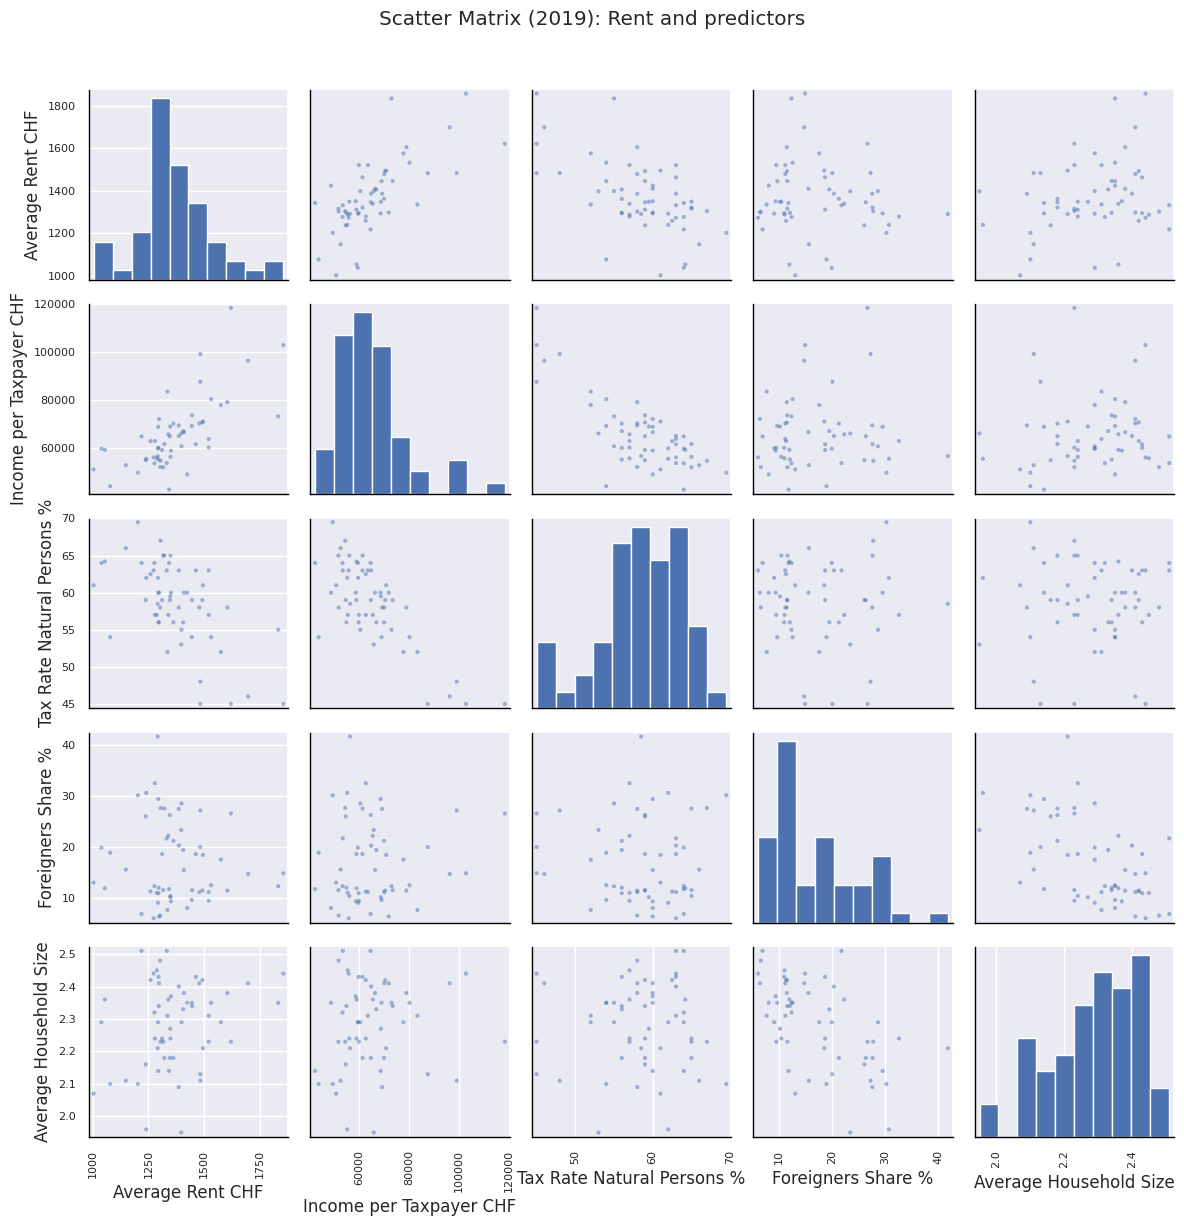

In [31]:
from pandas.plotting import scatter_matrix

vars_matrix = [
    "Average Rent CHF",
    "Income per Taxpayer CHF",
    "Tax Rate Natural Persons %",
    "Foreigners Share %",
    "Average Household Size"
]

vars_matrix = [v for v in vars_matrix if v in df.columns]

axes = scatter_matrix(
    df[vars_matrix],
    figsize=(12,12),
    diagonal="hist"
)

# Make axes borders clearer (prof-style)
for ax in axes.flatten():
    if ax is not None:
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")
        ax.spines["bottom"].set_linewidth(1.0)
        ax.spines["left"].set_linewidth(1.0)

plt.suptitle("Scatter Matrix (2019): Rent and predictors", y=1.02)
plt.tight_layout()
plt.show()

## Multivariate graphical EDA: Hexbin (Rent vs Income per Taxpayer)

Goal:
- Show density/clustering using hexagonal binning
- Focus on the strongest relationship: rent vs income per taxpayer

Output:
- Hexbin plot with colorbar (counts per hex)


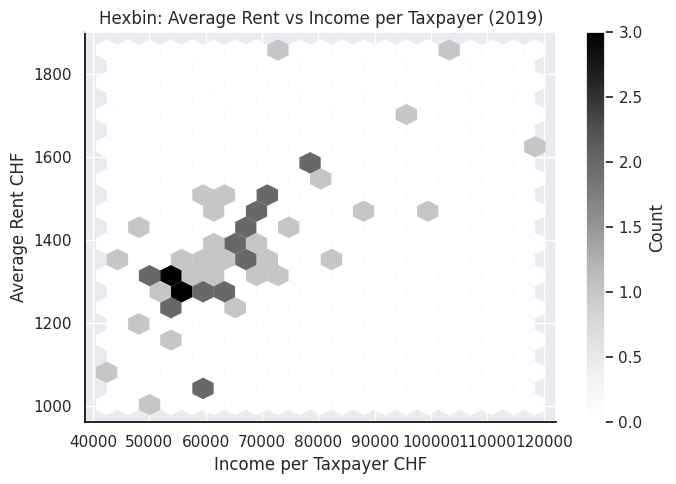

In [32]:
x_var = "Income per Taxpayer CHF"
y_var = "Average Rent CHF"

plt.figure(figsize=(7,5))
# Hexbin with white -> black gradient: low counts white, high counts black
hb = plt.hexbin(df[x_var], df[y_var], gridsize=20, cmap='Greys', edgecolors='none')
# Force color limits so 0 maps to white and max count maps to black
hb.set_clim(0, hb.get_array().max())
plt.colorbar(hb, label="Count")

plt.title("Hexbin: Average Rent vs Income per Taxpayer (2019)")
plt.xlabel(x_var)
plt.ylabel(y_var)

ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Geospatial setup (GeoPandas)

Goal:
- Load geospatial libraries to create municipality-level maps (choropleths)

Output:
- GeoPandas available for use


In [ ]:

# !pip -q install geopandas shapely pyproj fiona

import json
import requests
import geopandas as gpd


## Download municipality borders (GeoJSON) using BFS IDs

Output:
- gdf_borders: GeoDataFrame with one polygon per municipality


In [34]:
import time
import requests
import geopandas as gpd

bfs_ids = sorted(df["BFS ID"].unique().tolist())
print("Number of BFS IDs:", len(bfs_ids))

headers = {
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (ARM-EDA/1.0)"
}

features = []
failed = []

for bfs in bfs_ids:
    url = (
        "https://api3.geo.admin.ch/rest/services/api/MapServer/"
        f"ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill/{int(bfs)}"
        "?geometryFormat=geojson&sr=4326"
    )

    try:
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        data = r.json()

        # ✅ GeoAdmin returns a wrapper: {"feature": {...}}
        if isinstance(data, dict) and "feature" in data and isinstance(data["feature"], dict):
            feat = data["feature"]
        # (fallback) sometimes APIs return a direct GeoJSON Feature
        elif isinstance(data, dict) and data.get("type") == "Feature":
            feat = data
        else:
            failed.append((bfs, f"Unexpected response keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"))
            continue

        # Must have geometry for GeoPandas
        if "geometry" not in feat or feat["geometry"] is None:
            failed.append((bfs, "No geometry in feature"))
            continue

        feat.setdefault("properties", {})
        feat["properties"]["BFS ID"] = int(bfs)

        features.append(feat)
        time.sleep(0.05)  # polite pause

    except Exception as e:
        failed.append((bfs, str(e)))

print("Fetched features:", len(features))
print("Failed BFS IDs:", len(failed))

if failed:
    print("\nFirst 10 failures:")
    for item in failed[:10]:
        print("-", item)

# Create GeoDataFrame only if we have geometries
if len(features) == 0:
    raise RuntimeError("No geometries fetched. Something still blocks geometry retrieval.")

gdf_borders = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")

print("\nBorders GeoDataFrame shape:", gdf_borders.shape)
display(gdf_borders.head())


Number of BFS IDs: 58
Fetched features: 58
Failed BFS IDs: 0

Borders GeoDataFrame shape: (58, 16)


,geometry,gemname,gemflaeche,gde_hist_id,gde_nr,jahr,perimeter,kanton,objektart,is_current_jahr,objektart_lookup,link_de,link_fr,link_it,label,BFS ID
0,"MULTIPOLYGON (((7.55589 47.54434, 7.55581 47.5...",Allschwil,889.0000,13825,2762,2026,"14,948.5541",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Allschwil,2762
1,"MULTIPOLYGON (((7.60743 47.48939, 7.60738 47.4...",Arlesheim,693.0000,13826,2763,2026,"12,267.8492",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Arlesheim,2763
2,"MULTIPOLYGON (((7.5365 47.50506, 7.5365 47.505...",Biel-Benken,412.0000,13827,2764,2026,"10,701.3606",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Biel-Benken,2764
3,"MULTIPOLYGON (((7.55589 47.54434, 7.55655 47.5...",Binningen,446.0000,13828,2765,2026,"9,039.5102",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Binningen,2765
4,"MULTIPOLYGON (((7.6225 47.54243, 7.62278 47.54...",Birsfelden,251.0000,13829,2766,2026,"7,409.3457",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Birsfelden,2766


## Merge municipality borders with EDA dataset (2019)

Goal:
- Join municipality polygons (gdf_borders) with the EDA dataframe (df) via BFS ID
- Create one GeoDataFrame containing geometry + indicators

Output:
- gdf_map: GeoDataFrame ready for mapping


In [35]:
# Merge (inner join so only municipalities with both geometry + data remain)
gdf_map = gdf_borders.merge(df, on="BFS ID", how="inner")

print("gdf_borders shape:", gdf_borders.shape)
print("df shape:", df.shape)
print("gdf_map shape:", gdf_map.shape)

# Quick integrity checks
print("Missing geometry:", int(gdf_map["geometry"].isna().sum()))
print("Unique municipalities:", gdf_map["Municipality"].nunique())

display(gdf_map[["BFS ID", "Municipality"]].head())


gdf_borders shape: (58, 16)
df shape: (58, 8)
gdf_map shape: (58, 23)
Missing geometry: 0
Unique municipalities: 58


,BFS ID,Municipality
0,2762,Allschwil
1,2763,Arlesheim
2,2764,Biel-Benken
3,2765,Binningen
4,2766,Birsfelden


## Reproject to Swiss CRS (LV95)

Goal:
- Reproject geometries to a Swiss metric coordinate system (LV95 / EPSG:2056)
- This improves map proportions and readability compared to lat/long

Output:
- gdf_map_ch: GeoDataFrame in EPSG:2056


In [36]:
gdf_map_ch = gdf_map.to_crs(epsg=2056)

print("CRS after reprojection:", gdf_map_ch.crs)
display(gdf_map_ch.head())


CRS after reprojection: EPSG:2056


,geometry,gemname,gemflaeche,gde_hist_id,gde_nr,jahr,perimeter,kanton,objektart,is_current_jahr,objektart_lookup,link_de,link_fr,link_it,label,BFS ID,Year,Municipality,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
0,"MULTIPOLYGON (((2608828.352 1265964.057, 26088...",Allschwil,889.0000,13825,2762,2026,"14,948.5541",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Allschwil,2762,2019,Allschwil,"1,386.3910",58.0000,27.5400,2.0900,"69,297.6802"
1,"MULTIPOLYGON (((2612721.598 1259861.59, 261271...",Arlesheim,693.0000,13826,2763,2026,"12,267.8492",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Arlesheim,2763,2019,Arlesheim,"1,483.1575",45.0000,20.0400,2.1300,"87,560.1473"
2,"MULTIPOLYGON (((2607374.207 1261594.743, 26073...",Biel-Benken,412.0000,13827,2764,2026,"10,701.3606",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Biel-Benken,2764,2019,Biel-Benken,"1,698.3284",46.0000,14.7500,2.4100,"96,366.3632"
3,"MULTIPOLYGON (((2608828.352 1265964.057, 26088...",Binningen,446.0000,13828,2765,2026,"9,039.5102",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Binningen,2765,2019,Binningen,"1,483.7724",48.0000,27.2300,2.1100,"99,143.8997"
4,"MULTIPOLYGON (((2613843.477 1265761.257, 26138...",Birsfelden,251.0000,13829,2766,2026,"7,409.3457",BL,0,True,gemeindegebiet,https://www.agvchapp.bfs.admin.ch/de/communes/...,https://www.agvchapp.bfs.admin.ch/fr/communes/...,https://www.agvchapp.bfs.admin.ch/it/communes/...,Birsfelden,2766,2019,Birsfelden,"1,240.3278",62.0000,30.6800,1.9600,"55,344.9286"


## 2×2 Choropleth maps (Basel-Land, 2019)

Goal:
- Create a single figure with 4 municipality-level maps:
  1) Average Rent CHF
  2) Income per Taxpayer CHF
  3) Tax Rate Natural Persons %
  4) Foreigners Share %

Visualization rules:
- Municipality borders visible (black)
- Blue color scale (darker = higher values)
- One map per subplot (2×2 layout)

Output:
- One combined 2×2 figure (bonus geospatial visualization)

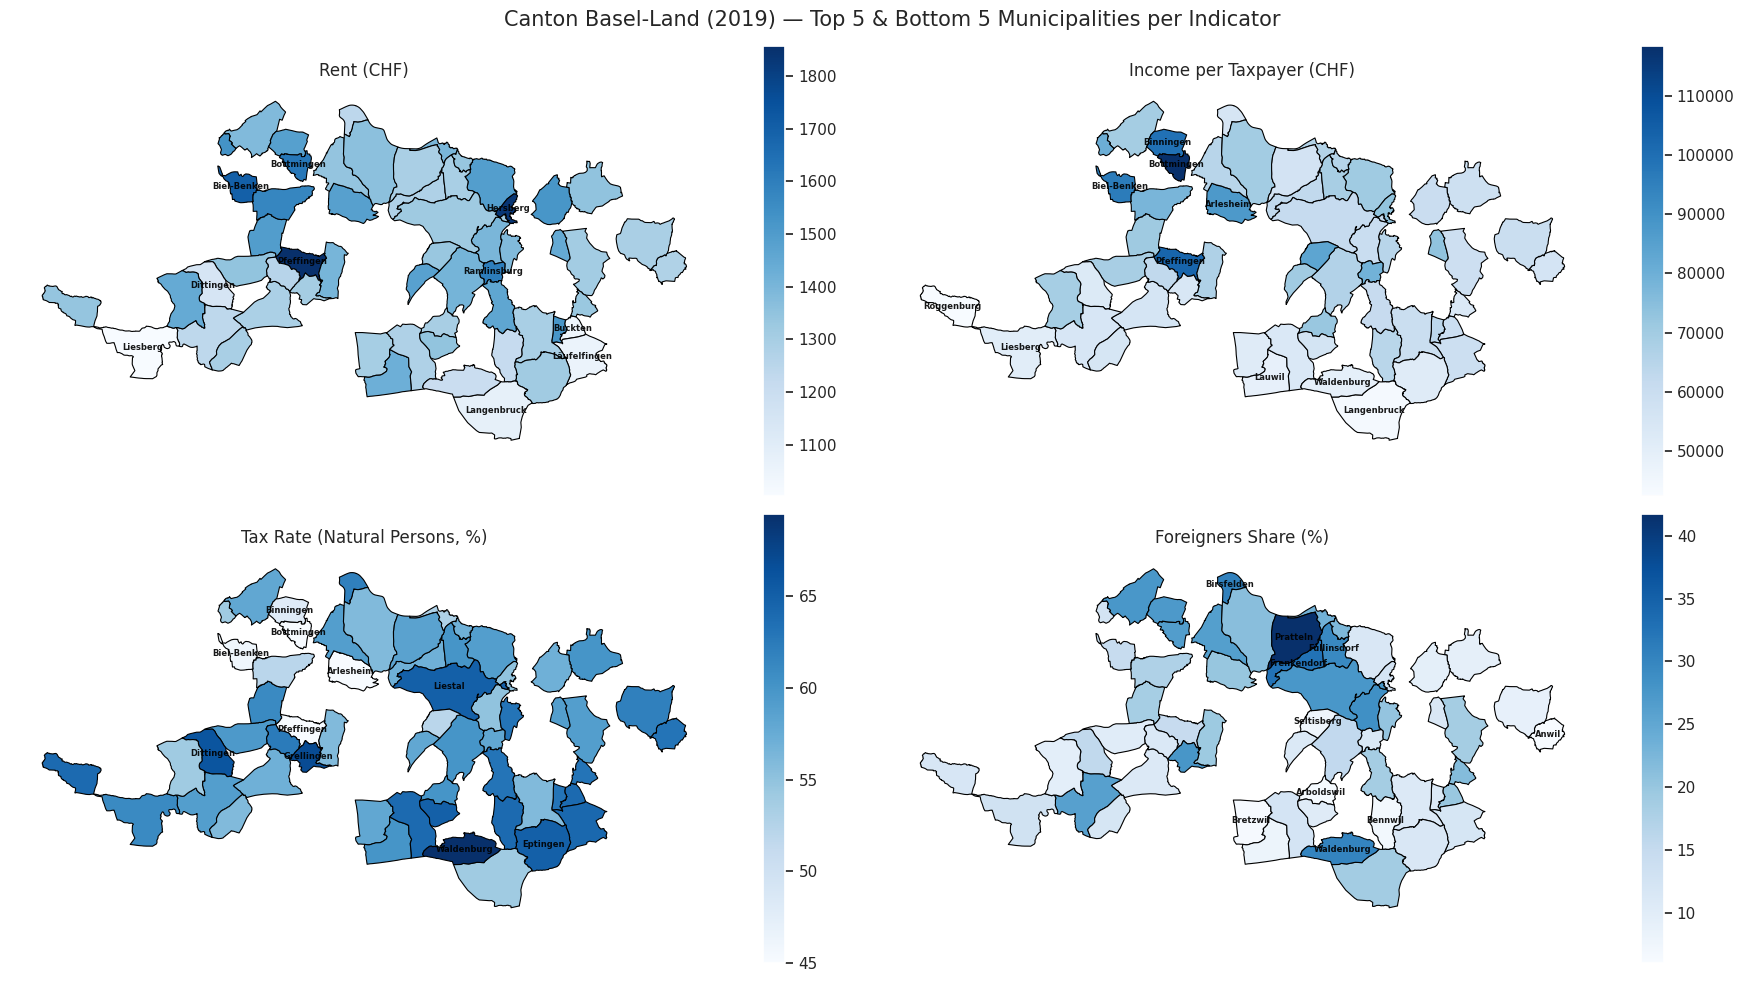

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

maps = [
    ("Average Rent CHF", "Rent (CHF)"),
    ("Income per Taxpayer CHF", "Income per Taxpayer (CHF)"),
    ("Tax Rate Natural Persons %", "Tax Rate (Natural Persons, %)"),
    ("Foreigners Share %", "Foreigners Share (%)")
]

for ax, (col, title) in zip(axes.flatten(), maps):
    # Plot all municipalities with color scale
    gdf_map_ch.plot(
        column=col,
        cmap="Blues",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )
    
    # Get top 5 and bottom 5 municipalities for this column
    top_5 = gdf_map_ch.nlargest(5, col)
    bottom_5 = gdf_map_ch.nsmallest(5, col)
    highlighted = pd.concat([top_5, bottom_5])
    
    # Add municipality names only for top 5 and bottom 5
    for idx, row in highlighted.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, 
            centroid.y, 
            row["Municipality"],
            fontsize=6,
            ha="center",
            va="center",
            weight="bold",
            color="black",
            alpha=0.9
        )
    
    ax.set_title(title, fontsize=12)
    ax.set_axis_off()

plt.suptitle("Canton Basel-Land (2019) — Top 5 & Bottom 5 Municipalities per Indicator", fontsize=15)
plt.tight_layout()
plt.show()

### Jupyter notebook --footer info--


In [38]:
import os
import platform
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')


-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2026-01-17 11:29:18
Python Version: 3.11.14
-----------------------------------
